In [1]:
#  this script is meant to deal with the data of 8 recognition runs and generate models saved in corresponding folder
'''
input:
    cfg.session=ses1
    cfg.modelFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/clf/"
    cfg.dataFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/"
output:
    models in cfg.modelFolder
'''


import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
from subprocess import call
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
from rtCommon.fileClient import FileInterface
import rtCommon.projectUtils as projUtils
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


# argParser = argparse.ArgumentParser()
# argParser.add_argument('--config', '-c', default='sub001.ses1.toml', type=str, help='experiment file (.json or .toml)')
# args = argParser.parse_args()
from rtCommon.cfg_loading import mkdir,cfg_loading
cfg = cfg_loading("sub001.ses1.toml")

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


In [43]:
'''
convert all dicom files into nii files in the temp dir. 
find the middle volume of the run1 as the template volume
align every other functional volume with templateFunctionalVolume (3dvolreg)
'''
# recognition_preprocess(cfg)
'''
purpose: 
    prepare data for the model training code.
steps:
    convert all dicom files into nii files in the temp dir. 
    find the middle volume of the run1 as the template volume
    align every other functional volume with templateFunctionalVolume (3dvolreg)
'''


# import and set up environment
import sys
from subprocess import call
import nibabel as nib
import pydicom as dicom
import numpy as np
import time
import os
from glob import glob
import shutil
import pandas as pd
# from import convertDicomFileToNifti
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti, readDicomFromFile
from rtCommon.cfg_loading import mkdir,cfg_loading

# # convert all dicom files into nii files in the temp dir. 
# tmp_dir=f"{cfg.tmp_folder}{time.time()}/" ; mkdir(tmp_dir)
# dicomFiles=glob(f"{cfg.dicom_dir}/*.dcm") ; dicomFiles.sort()
# for curr_dicom in dicomFiles:
#     dicomImg = readDicomFromFile(curr_dicom) # read dicom file
#     convertDicomImgToNifti(dicomImg, dicomFilename=f"{tmp_dir}/{curr_dicom.split('/')[-1]}") #convert dicom to nii    
#     # os.remove(f"{tmp_dir}/{curr_dicom.split('/')[-1]}") # remove temp dcm file

# # find the middle volume of the run1 as the template volume
# tmp=glob(f"{tmp_dir}/001_000001*.nii") ; tmp.sort()
# cfg.templateFunctionalVolume = f"{cfg.recognition_dir}/templateFunctionalVolume.nii" 
# call(f"cp {tmp[int(len(tmp)/2)]} {cfg.templateFunctionalVolume}", shell=True)

# # align every other functional volume with templateFunctionalVolume (3dvolreg)
# allTRs=glob(f"{tmp_dir}/001_*.nii") ; allTRs.sort()

# # select a list of run IDs based on the runRecording.csv, actualRuns would be [1,2] is the 1st and the 3rd runs are recognition runs.
# runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
# actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])])
# for curr_run in actualRuns:
#     outputFileNames=[]
#     runTRs=glob(f"{tmp_dir}/001_{str(curr_run).zfill(6)}_*.nii") ; runTRs.sort()
#     for curr_TR in runTRs:
#         command = f"3dvolreg \
#             -base {cfg.templateFunctionalVolume} \
#             -prefix  {curr_TR[0:-4]}_aligned.nii \
#             {curr_TR}"
#         call(command,shell=True)
#         outputFileNames.append(f"{curr_TR[0:-4]}_aligned.nii")
#     files=''
#     for f in outputFileNames:
#         files=files+' '+f
#     command=f"fslmerge -t {cfg.recognition_dir}run{curr_run}.nii {files}"
#     print('running',command)
#     call(command, shell=True)

# # remove the tmp folder
# shutil.rmtree(tmp_dir)

# load and apply mask

'''
for each run, 
    load behavior data 
    push the behavior data back for 2 TRs
    save the brain TRs with images
    save the behavior data
'''
from tqdm import tqdm
for curr_run_i,curr_run in tqdm(enumerate(actualRuns)):
    # load behavior data
    behav_data = behaviorDataLoading(cfg,curr_run_i+1)

    # brain data is first aligned by pushed back 2TR(4s)
    brain_data = nib.load(f"{cfg.recognition_dir}run{curr_run}.nii.gz").get_data() ; brain_data=np.transpose(brain_data,(3,0,1,2))
    Brain_TR=np.arange(brain_data.shape[0])
    Brain_TR = Brain_TR+2

    # select volumes of brain_data by counting which TR is left in behav_data
    Brain_TR=Brain_TR[list(behav_data['TR'])] # original TR begin with 0
    if Brain_TR[-1]>=brain_data.shape[0]:
        Brain_TR = Brain_TR[:-1]
        behav_data = behav_data.drop([behav_data.iloc[-1].TR])
    brain_data=brain_data[Brain_TR]
    np.save(f"{cfg.recognition_dir}brain_run{curr_run}.npy", brain_data)
    # save the behavior data
    behav_data.to_csv(f"{cfg.recognition_dir}behav_run{curr_run}.csv")


0it [00:00, ?it/s]/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
1it [00:00,  1.16it/s]/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
2it [00:01,  1.28it/s]/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipyk

In [45]:
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading
'''
load preprocessed and aligned behavior and brain data 
select data with the wanted pattern like AB AC AD BC BD CD 
train correspondng classifier and save the classifier performance and the classifiers themselves.
'''
minimalClass(cfg)

KeyboardInterrupt: 

In [81]:
'''
purpose: 
    train offline models

steps:
    load preprocessed and aligned behavior and brain data 
    select data with the wanted pattern like AB AC AD BC BD CD 
    train correspondng classifier and save the classifier performance and the classifiers themselves.

'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


def normalize(X):
    X = X - X.mean(0)
    return X

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def get_inds(X, Y, pair, testRun=None):

    inds = {}

    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label

    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                             multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]

    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X

    return inds

if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
else:
    main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

working_dir=main_dir
os.chdir(working_dir)

'''
if you read runRecording for current session and found that there are only 4 runs in the current session, 
you read the runRecording for previous session and fetch the last 4 recognition runs from previous session
'''
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]
if len(actualRuns) < 8:
    runRecording_preDay = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session}/recognition/../runRecording.csv")
    actualRuns_preDay = list(runRecording_preDay['run'].iloc[list(np.where(1==1*(runRecording_preDay['type']=='recognition'))[0])])[-(8-len(actualRuns)):] # might be [5,6,7,8]
else: 
    actualRuns_preDay = []

assert len(actualRuns_preDay)+len(actualRuns)==8 

objects = ['bed', 'bench', 'chair', 'table']

for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    mask = nib.load(f"{cfg.recognition_dir}chosenMask.nii.gz").get_data()
    t = t[:,mask==1]
    brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    tt = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    behav_data=tt if ii==0 else pd.concat([behav_data,tt])

for ii,run in enumerate(actualRuns_preDay): # load behavior and brain data for previous session
    t = np.load(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/brain_run{run}.npy")
    mask = nib.load(f"{cfg.recognition_dir}chosenMask.nii.gz").get_data()
    t = t[:,mask==1]
    brain_data = np.concatenate((brain_data,t), axis=0)

    tt = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/behav_run{run}.csv")
    behav_data = pd.concat([behav_data,tt])

FEAT=brain_data.reshape(brain_data.shape[0],-1)
META=behav_data

# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}
label=[]
for curr_trial in range(META.shape[0]):
    label.append(imcodeDict[META['Item'].iloc[curr_trial]])
META['label']=label # merge the label column with the data dataframe

# Which run to use as test data (leave as None to not have test data)
testRun = 2 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

allpairs = itertools.combinations(objects,2)
# Iterate over all the possible target pairs of objects
for pair in allpairs:
    # Find the control (remaining) objects for this pair
    altpair = other(pair)

    # pull sorted indices for each of the critical objects, in order of importance (low to high)
    # inds = get_inds(FEAT, META, pair, testRun=testRun)

    # Find the number of voxels that will be left given your inclusion parameter above
    # nvox = red_vox(FEAT.shape[1], include)

    for obj in pair:
        # foil = [i for i in pair if i != obj][0]
        for altobj in altpair:

            # establish a naming convention where it is $TARGET_$CLASSIFICATION
            # Target is the NF pair (e.g. bed/bench)
            # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
            naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

            # Pull the relevant inds from your previously established dictionary 
            # obj_inds = inds[obj]

            # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
#             if testRun:
#                 trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
#                 testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
#             else:
#                 trainIX = META.index[(META['label'].isin([obj, altobj]))]
#                 testIX = META.index[(META['label'].isin([obj, altobj]))]
#             # pull training and test data
#             trainX = FEAT[trainIX]
#             testX = FEAT[testIX]
#             trainY = META.iloc[trainIX].label
#             testY = META.iloc[testIX].label

            if testRun:
                trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
            else:
                trainIX = ((META['label']==obj) + (META['label']==altobj))
                testIX = ((META['label']==obj) + (META['label']==altobj))

            # pull training and test data
            trainX = FEAT[trainIX]
            testX = FEAT[testIX]
            trainY = META.iloc[np.asarray(trainIX)].label
            testY = META.iloc[np.asarray(testIX)].label

            print(f"obj={obj},altobj={altobj}")
            print(f"unique(trainY)={np.unique(trainY)}")
            print(f"unique(testY)={np.unique(testY)}")
            assert len(np.unique(trainY))==2


            # # If you're selecting high-importance features, this bit handles that
            # if include < 1:
            #     trainX = trainX[:, obj_inds[-nvox:]]
            #     testX = testX[:, obj_inds[-nvox:]]

            # Train your classifier
            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                     multi_class='multinomial').fit(trainX, trainY)

            model_folder = cfg.trainingModel_dir
            # Save it for later use
            joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            print(naming, acc)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' in

obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


bedbench_bedchair 0.4583333333333333
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedtable 0.4583333333333333
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_benchchair 0.5217391304347826
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchtable 0.5217391304347826
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
bedchair_bedbench 0.4782608695652174
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedchair_bedtable 0.4583333333333333
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedchair_chairbench 0.5217391304347826
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedchair_chairtable 0.625
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_bedbench 0.4782608695652174
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_bedchair 0.4583333333333333
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedtable_tablebench 0.5217391304347826
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedtable_tablechair 0.625
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_benchbed 0.4782608695652174
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_benchtable 0.5217391304347826
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchchair_chairbed 0.4583333333333333
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
benchchair_chairtable 0.625
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchtable_benchbed 0.4782608695652174
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchtable_benchchair 0.5217391304347826
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
benchtable_tablebed 0.4583333333333333
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchtable_tablechair 0.625
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

chairtable_chairbed 0.4583333333333333
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_chairbench 0.5217391304347826
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']
chairtable_tablebed 0.4583333333333333
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

chairtable_tablebench 0.5217391304347826


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [80]:
naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

# Pull the relevant inds from your previously established dictionary 
# obj_inds = inds[obj]

# If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter

if testRun:
    trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
    testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
else:
    trainIX = ((META['label']==obj) + (META['label']==altobj))
    testIX = ((META['label']==obj) + (META['label']==altobj))

# pull training and test data
trainX = FEAT[trainIX]
testX = FEAT[testIX]
trainY = META.iloc[np.asarray(trainIX)].label
testY = META.iloc[np.asarray(testIX)].label

print(f"obj={obj},altobj={altobj}")
print(f"unique(trainY)={np.unique(trainY)}")
print(f"unique(testY)={np.unique(testY)}")
assert len(np.unique(trainY))==2


obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

In [53]:
META

,Unnamed: 0,TR,image_on,Resp,Item,isCorrect,subj,run_num,label
0,3,3,5.999537,2.0,D,True,sub001,1,bench
1,5,5,9.999614,2.0,B,True,sub001,1,chair
2,8,8,15.999709,1.0,A,True,sub001,1,bed
3,12,12,23.999743,1.0,C,True,sub001,1,table
4,15,15,29.999806,2.0,D,True,sub001,1,bench
...,...,...,...,...,...,...,...,...,...
42,130,130,260.008890,1.0,A,True,sub001,8,bed
43,132,132,264.008975,2.0,D,True,sub001,8,bench
44,134,134,268.008995,2.0,B,True,sub001,8,chair
45,137,137,274.009081,1.0,C,True,sub001,8,table


In [83]:
type(cfg.session)

int

In [5]:
#  this script is meant to deal with the data of 8 recognition runs and generate models saved in corresponding folder
'''
input:
    cfg.session=ses1
    cfg.modelFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/clf/"
    cfg.dataFolder=f"{cfg.subjects_dir}/{cfg.subjectName}/{cfg.session}_recognition/"
output:
    models in cfg.modelFolder
'''


import os
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import numpy as np
import nibabel as nib
import scipy.io as sio
from subprocess import call
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
import time
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
from rtCommon.fileClient import FileInterface
import rtCommon.projectUtils as projUtils
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti


from rtCommon.cfg_loading import mkdir,cfg_loading
config="sub001.ses1.toml"
cfg = cfg_loading(config)

sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/')
from recognition_dataAnalysisFunctions import recognition_preprocess,minimalClass,behaviorDataLoading


In [6]:
print(f"bash {cfg.recognition_expScripts_dir}runAggregate.sh {config}")

bash /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/runAggregate.sh sub001.ses1.toml


# aggregate.py

In [11]:
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import numpy as np
import nibabel as nib
import os
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
import argparse
import scipy.io as sio
from subprocess import call
from nibabel.nicom import dicomreaders
import pydicom as dicom  # type: ignore
from glob import glob
import shutil
from nilearn.image import new_img_like
import joblib
import rtCommon.utils as utils
from rtCommon.utils import loadConfigFile
from rtCommon.fileClient import FileInterface
import rtCommon.projectUtils as projUtils
from rtCommon.imageHandling import readRetryDicomFromFileInterface, getDicomFileName, convertDicomImgToNifti
from rtCommon.cfg_loading import mkdir,cfg_loading


'''
Takes args (in order):
    toml
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang or schaefer)
    N (the number of parcels or ROIs to start with)
'''
toml = "sub001.ses1.toml" #sys.argv[1] # 
cfg = cfg_loading(toml) 
N = 20 #int(sys.argv[4]) # 20
roiloc = "schaefer" #str(sys.argv[3]) #wang or schaefer 
print("Using user-selected roi location: {}".format(roiloc))
dataSource = "realtime" #sys.argv[2]  # could be neurosketch or realtime
print("Using {} data".format(dataSource))
print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(cfg.subjectName, dataSource, roiloc, N))


# if dataSource == "neurosketch":
#     funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
#     metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
#     anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
# elif dataSource == "realtime":
#     funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
#     metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
#     anat = "$TO_BE_FILLED"
# else:
#     funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
#     metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
#     anat = "$TO_BE_FILLED"
    
starttime = time.time()

outloc = f'{cfg.recognition_dir}classRegions/'


if roiloc == "schaefer":
    topN = []
    for roinum in range(1,301):
        result = np.load(f"{outloc}/{roiloc}_{roinum}_.npy")
        RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULTix = RESULT[:,0].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        print(topN[-1])
else:
    topN = []
    for hemi in ["lh", "rh"]:
        for roinum in range(1, 26):
            result = np.load(f"{outloc}/{roiloc}_roi{roinum}_{hemi}.npy")
            Result = result if roinum == 1 else np.vstack((Result, result))
        RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))

    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        print(topN[-1])


def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))
        
def normalize(X):
    X = X - X.mean(3)
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


# phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

Using user-selected roi location: schaefer
Using realtime data
Running subject sub001, with realtime as a data source, schaefer, starting with 20 ROIs
130.nii.gz
160.nii.gz
57.nii.gz
8.nii.gz
28.nii.gz
157.nii.gz
171.nii.gz
20.nii.gz
154.nii.gz
159.nii.gz
169.nii.gz
11.nii.gz
6.nii.gz
19.nii.gz
15.nii.gz
16.nii.gz
163.nii.gz
10.nii.gz
14.nii.gz
165.nii.gz


In [33]:
for pn, parc in enumerate(topN):
    _mask = nib.load(f'{cfg.recognition_dir}mask/{roiloc}_{parc}')
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
    mask[mask>0] = 1
print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
cfg.actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])])

# Compile preprocessed data and corresponding indices
metas = []
runs=[]
for run_i,run in enumerate(cfg.actualRuns):
    print(run, end='--')
    # Build the path for the preprocessed functional data
    this4d = f"{cfg.recognition_dir}run{run}.nii.gz" # run data
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(f"{cfg.recognition_dir}{cfg.subjectName}_{run_i+1}.csv")

    TR_num = list(thismeta.TR.astype(int))
    labels = list(thismeta.Item)
    labels = [None if type(label)==float else imcodeDict[label] for label in labels]


    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+2] for n in TR_num]
    features = np.array(features)
    features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    featmean = features.mean(1)[..., None]
    features = features - featmean
    
    # Append both so we can use it later
    metas.append(labels)
    runs.append(features) # if run_i == 0 else np.concatenate((runs, features))

# dimsize = runIm.header.get_zooms()

# data = []
# # Preset the variables
# print("Runs shape", runs.shape)
# _data = runs
# print(_data.shape)
# data.append(_data)
# print("shape of data: {}".format(_data.shape))
    
# bcvar = [metas]
                 
# # Distribute the information to the searchlights (preparing it to run)
# slstart = time.time()
# sl_result = Class(data, bcvar)
# print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))

# SL = time.time() - slstart
# tot = time.time() - starttime
# print('total time: {}, searchlight time: {}'.format(tot, SL))

# #SAVE accuracy

# outfile = f"{cfg.recognition_dir}classRegions/{roiloc}_top{N}.npy"
# np.save(outfile, np.array(sl_result))
# #SAVE mask
# savemask = nib.Nifti1Image(mask, affine=aff)
# nib.save(savemask, f"{cfg.recognition_dir}classRegions/{roiloc}_top{N}mask.nii.gz")
# #SAVE roilist, nvox
# ROILIST = [r for r in topN]
# ROILIST.append(np.sum(mask))
# ROILIST = pd.DataFrame(ROILIST)
# ROILIST.to_csv(f"{cfg.recognition_dir}classRegions/{roiloc}_top{N}.csv")




/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


mask dimensions: (64, 64, 36)
number of voxels in mask: 1980
2--LENGTH OF TR: 140


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (140, 1980) shape of mask (64, 64, 36)
3--LENGTH OF TR: 148
shape of features (148, 1980) shape of mask (64, 64, 36)
4--LENGTH OF TR: 147
shape of features (147, 1980) shape of mask (64, 64, 36)
5--LENGTH OF TR: 143
shape of features (143, 1980) shape of mask (64, 64, 36)
6--LENGTH OF TR: 146
shape of features (146, 1980) shape of mask (64, 64, 36)
7--LENGTH OF TR: 148
shape of features (148, 1980) shape of mask (64, 64, 36)
9--LENGTH OF TR: 139
shape of features (139, 1980) shape of mask (64, 64, 36)
10--LENGTH OF TR: 145
shape of features (145, 1980) shape of mask (64, 64, 36)


In [40]:

def Class(data, bcvar):
    metas = bcvar
    data4d = data
    accs = []
    for curr_run in range(8):
        testX = data4d[curr_run]
        testY = metas[curr_run]
        trainX=None
        for train_run in range(8):
            if train_run!=curr_run:
                trainX = data4d[train_run] if type(trainX)!=np.ndarray else np.concatenate((trainX, data4d[train_run]),axis=0)
        trainY = []
        for train_run in range(8):
            if train_run!=curr_run:
                trainY.extend(metas[train_run])
        # remove nan type
        id=[type(i)==str for i in trainY]
        trainY=[i for i in trainY if type(i)==str]
        trainX=trainX[id]

        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        id=[type(i)==str for i in testY]
        testY=[i for i in testY if type(i)==str]
        testX=testX[id]
        acc = clf.score(testX, testY)
        accs.append(acc)
    return np.mean(accs)
data = runs
bcvar = metas
accs=Class(data, bcvar)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

In [45]:
sl_result=accs
print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))

# SL = time.time() - slstart
# tot = time.time() - starttime
# print('total time: {}, searchlight time: {}'.format(tot, SL))

#SAVE accuracy

outfile = f"{cfg.recognition_dir}classRegions/{roiloc}_top{N}.npy"
np.save(outfile, np.array(sl_result))
#SAVE mask
savemask = nib.Nifti1Image(mask, affine=aff)
nib.save(savemask, f"{cfg.recognition_dir}classRegions/{roiloc}_top{N}mask.nii.gz")
#SAVE roilist, nvox
ROILIST = [r for r in topN]
ROILIST.append(np.sum(mask))
ROILIST = pd.DataFrame(ROILIST)
ROILIST.to_csv(f"{cfg.recognition_dir}classRegions/{roiloc}_top{N}.csv")


results of classifier: 0.6171875, type: <class 'numpy.float64'>


In [43]:

outfile = f"{cfg.recognition_dir}classRegions/{roiloc}_top{N}.npy"
outfile

'/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses1/recognition/classRegions/schaefer_top20.npy'

In [46]:
f"bash {cfg.recognition_expScripts_dir}runAggregate.sh {config}"

'bash /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/expScripts/recognition/runAggregate.sh sub001.ses1.toml'

In [ ]:
from rtCommon.cfg_loading import mkdir,cfg_loading
from glob import glob
toml="sub001.ses1.toml"
cfg = cfg_loading(toml) 
subjects=cfg.subjectName

# testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subs)))
roiloc="wang"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        except:
            pass

schaeferAcc=np.zeros((300,3))
roiloc="schaefer"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        except:
            pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g')
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b')

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")

Text(0, 0.5, 'accuracy')

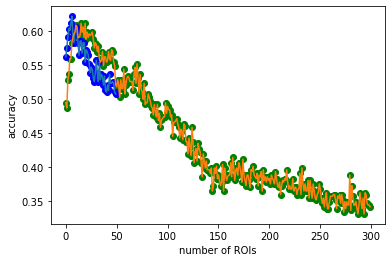

In [51]:
import sys
sys.path.append('/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/')
from rtCommon.cfg_loading import mkdir,cfg_loading
from glob import glob

toml="sub001.ses1.toml"
cfg = cfg_loading(toml) 
subjects=[cfg.subjectName]

# testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
hemis=["lh", "rh"]

wangAcc=np.zeros((50,len(subjects)))
roiloc="wang"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{cfg.recognition_dir}classRegions/{roiloc}_top{num}.npy")
        except:
            pass

schaeferAcc=np.zeros((300,len(subjects)))
roiloc="schaefer"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{cfg.recognition_dir}classRegions/{roiloc}_top{num}.npy")
        except:
            pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g')
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b')

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")

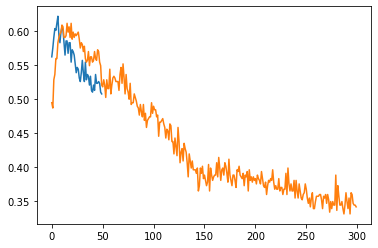

In [52]:
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))



In [63]:
print(f"fslview_deprecated {cfg.recognition_dir}wanginfunc.nii.gz \
    {cfg.recognition_dir}classRegions/wang_top{bestN}mask.nii.gz")

fslview_deprecated /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses1/recognition/wanginfunc.nii.gz     /gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses1/recognition/classRegions/wang_top20mask.nii.gz


In [64]:
cfg.chosenMask

'/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses1/recognition/chosenMask.nii.gz'

In [65]:
from shutil import copyfile

copyfile(f"{cfg.recognition_dir}classRegions/wang_top{bestN}mask.nii.gz", 
         cfg.chosenMask
        )


'/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses1/recognition/chosenMask.nii.gz'

In [7]:
'''
purpose: 
    train offline models

steps:
    load preprocessed and aligned behavior and brain data 
    select data with the wanted pattern like AB AC AD BC BD CD 
    train correspondng classifier and save the classifier performance and the classifiers themselves.

'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


def normalize(X):
    X = X - X.mean(0)
    return X

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def get_inds(X, Y, pair, testRun=None):

    inds = {}

    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label

    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                             multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]

    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X

    return inds

if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/'
else:
    main_dir='/Volumes/GoogleDrive/My Drive/Turk_Browne_Lab/rtcloud_kp/'

working_dir=main_dir
os.chdir(working_dir)

'''
if you read runRecording for current session and found that there are only 4 runs in the current session, 
you read the runRecording for previous session and fetch the last 4 recognition runs from previous session
'''
runRecording = pd.read_csv(f"{cfg.recognition_dir}../runRecording.csv")
actualRuns = list(runRecording['run'].iloc[list(np.where(1==1*(runRecording['type']=='recognition'))[0])]) # can be [1,2,3,4,5,6,7,8] or [1,2,4,5]
if len(actualRuns) < 8:
    runRecording_preDay = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session}/recognition/../runRecording.csv")
    actualRuns_preDay = list(runRecording_preDay['run'].iloc[list(np.where(1==1*(runRecording_preDay['type']=='recognition'))[0])])[-(8-len(actualRuns)):] # might be [5,6,7,8]
else: 
    actualRuns_preDay = []

assert len(actualRuns_preDay)+len(actualRuns)==8 

objects = ['bed', 'bench', 'chair', 'table']

for ii,run in enumerate(actualRuns): # load behavior and brain data for current session
    t = np.load(f"{cfg.recognition_dir}brain_run{run}.npy")
    mask = nib.load(f"{cfg.chosenMask}").get_data()
    t = t[:,mask==1]
    brain_data=t if ii==0 else np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.recognition_dir}behav_run{run}.csv")
    behav_data=t if ii==0 else pd.concat([behav_data,t])

for ii,run in enumerate(actualRuns_preDay): # load behavior and brain data for previous session
    t = np.load(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/brain_run{run}.npy")
    mask = nib.load(f"{cfg.chosenMask}").get_data()
    t = t[:,mask==1]
    brain_data = np.concatenate((brain_data,t), axis=0)

    t = pd.read_csv(f"{cfg.subjects_dir}{cfg.subjectName}/ses{cfg.session-1}/recognition/behav_run{run}.csv")
    behav_data = pd.concat([behav_data,t])

FEAT=brain_data.reshape(brain_data.shape[0],-1)
META=behav_data

# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}
label=[]
for curr_trial in range(META.shape[0]):
    label.append(imcodeDict[META['Item'].iloc[curr_trial]])
META['label']=label # merge the label column with the data dataframe

# Which run to use as test data (leave as None to not have test data)
testRun = 2 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

# Decide on the proportion of crescent data to use for classification
include = 1
accuracyContainer=[]


allpairs = itertools.combinations(objects,2)

# Iterate over all the possible target pairs of objects
for pair in allpairs:
    # Find the control (remaining) objects for this pair
    altpair = other(pair)

    # pull sorted indices for each of the critical objects, in order of importance (low to high)
    # inds = get_inds(FEAT, META, pair, testRun=testRun)

    # Find the number of voxels that will be left given your inclusion parameter above
    # nvox = red_vox(FEAT.shape[1], include)

    for obj in pair:
        # foil = [i for i in pair if i != obj][0]
        for altobj in altpair:

            # establish a naming convention where it is $TARGET_$CLASSIFICATION
            # Target is the NF pair (e.g. bed/bench)
            # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
            naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

            # Pull the relevant inds from your previously established dictionary 
            # obj_inds = inds[obj]

            # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
            # if testRun:
            #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
            #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
            # else:
            #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
            #     testIX = META.index[(META['label'].isin([obj, altobj]))]
            # # pull training and test data
            # trainX = FEAT[trainIX]
            # testX = FEAT[testIX]
            # trainY = META.iloc[trainIX].label
            # testY = META.iloc[testIX].label

            # print(f"obj={obj},altobj={altobj}")
            # print(f"unique(trainY)={np.unique(trainY)}")
            # print(f"unique(testY)={np.unique(testY)}")
            # assert len(np.unique(trainY))==2

            if testRun:
                trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
            else:
                trainIX = ((META['label']==obj) + (META['label']==altobj))
                testIX = ((META['label']==obj) + (META['label']==altobj))
            # pull training and test data
            trainX = FEAT[trainIX]
            testX = FEAT[testIX]
            trainY = META.iloc[np.asarray(trainIX)].label
            testY = META.iloc[np.asarray(testIX)].label

            print(f"obj={obj},altobj={altobj}")
            print(f"unique(trainY)={np.unique(trainY)}")
            print(f"unique(testY)={np.unique(testY)}")
            assert len(np.unique(trainY))==2

            # # If you're selecting high-importance features, this bit handles that
            # if include < 1:
            #     trainX = trainX[:, obj_inds[-nvox:]]
            #     testX = testX[:, obj_inds[-nvox:]]

            # Train your classifier
            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                     multi_class='multinomial').fit(trainX, trainY)

            model_folder = cfg.trainingModel_dir
            # Save it for later use
            joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            print(naming, acc)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' in

obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
bedbench_bedchair 1.0
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedbench_bedtable 0.5
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchchair 0.6521739130434783
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedbench_benchtable 1.0
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']
bedchair_bedbench 1.0
obj=bed,altobj=table
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedchair_bedtable 0.5
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

bedchair_chairbench 0.6521739130434783
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedchair_chairtable 0.9166666666666666
obj=bed,altobj=bench
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_bedbench 1.0
obj=bed,altobj=chair
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_bedchair 1.0
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

bedtable_tablebench 1.0
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
bedtable_tablechair 0.9166666666666666
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_benchbed 1.0
obj=bench,altobj=table
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_benchtable 1.0
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']
benchchair_chairbed 1.0
obj=chair,altobj=table
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchchair_chairtable 0.9166666666666666
obj=bench,altobj=bed
unique(trainY)=['bed' 'bench']
unique(testY)=['bed' 'bench']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchtable_benchbed 1.0
obj=bench,altobj=chair
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

benchtable_benchchair 0.6521739130434783
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

benchtable_tablebed 0.5
obj=table,altobj=chair
unique(trainY)=['chair' 'table']
unique(testY)=['chair' 'table']
benchtable_tablechair 0.9166666666666666
obj=chair,altobj=bed
unique(trainY)=['bed' 'chair']
unique(testY)=['bed' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

chairtable_chairbed 1.0
obj=chair,altobj=bench
unique(trainY)=['bench' 'chair']
unique(testY)=['bench' 'chair']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/use

chairtable_chairbench 0.6521739130434783
obj=table,altobj=bed
unique(trainY)=['bed' 'table']
unique(testY)=['bed' 'table']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/pandas/core/com

chairtable_tablebed 0.5
obj=table,altobj=bench
unique(trainY)=['bench' 'table']
unique(testY)=['bench' 'table']
chairtable_tablebench 1.0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [3]:
mask=nib.load(cfg.chosenMask).get_data()

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


In [4]:
mask.shape

(64, 64, 36)

In [6]:
cfg.chosenMask

'/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/subjects/sub001/ses1/recognition/chosenMask.nii.gz'